In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage      
import sklearn.feature_extraction.text as sk_text
import sklearn.cluster as sk_cluster
import sklearn.metrics as metrics
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
import datetime
startTime = datetime.datetime.now()
print(str(startTime))

2019-03-08 13:31:40.486911


In [2]:
#print initial data

tweets = pd.read_csv('clean_data.csv',dtype=str)
tweets['FrequencyOver20'] = tweets.FrequencyOver20.str.lower()
tweets.head()


,Unnamed: 0,Name,ScreenName,UserID,FollowersCount,FriendsCount,Location,Description,CreatedAt,StatusID,Language,Place,RetweetCount,FavoriteCount,Text,HashMentions,FrequencyOver20,LocationSplit
0,6,David Walling,davidjwalling,106568768,975,2781,"Dallas, TX",Bloodletting secure algorithms close to the bone. #HealthIT security matters. Opinions my own. https://t.co/Dcpe6FteOq,Sat Oct 29 00:16:48 EEST 2016,792112907488079872,en,NaN,0,0,#infosec #Intel #ACM #IEEE Impacts Haswell microarch. Paper proposes mitigations that could prevent BTB-based side https://t.co/DW6vgRAPrv,#infosec #Intel #ACM #IEEE,#infosec,Dallas
1,13,Harry Binford,CaptainNormal,2447279666,895,1224,USA,"Proud Christian husband, frequent shooting range attendee, and former law enforcement. Lifetime member of the NRA. Pro-life, Jesus is Lord. America first.",Thu Oct 27 21:44:44 EEST 2016,791712249685676032,en,NaN,0,0,@WayneDupreeShow #climatechange is the democrats' attempt to play God,@WayneDupreeShow #climatechange,@waynedupreeshow #climatechange,USA
2,24,Deplorable Mina,minasmith64,2307021294,6808,6998,127.0.0.1,"Farm owner, horse lover, gun lover. Anti-Feminist. #RedneckTaliban:Warrant Officer (honorary) #GamerGate #AltRight #Trump2016",Wed Oct 26 16:02:10 EEST 2016,791263651617394688,en,"PlaceJSONImpl{name='Elgin', streetAddress='null', countryCode='US', id='7c4ae4537997a58f', country='United States', placeType='city', url='https://api.twitter.com/1.1/geo/id/7c4ae4537997a58f.json', fullName='Elgin, IL', boundingBoxType='Polygon', boundingBoxCoordinates=[[Ltwitter4j.GeoLocation;@274e98b7], geometryType='null', geometryCoordinates=null, containedWithIn=[]}",0,0,Too bad #MegynKelly remains obsessed w hammering every #Trump2016 surrogate on her show w salacious sex charges no https://t.co/SPWkgHpqcE,#MegynKelly #Trump2016,#megynkelly #trump2016,127.0.0.1
3,34,My Info,chrisf91,2424856262,129,822,"San Antonio, TX","im not supersticous, but... i am a little sticious...",Fri Oct 28 09:34:20 EEST 2016,791890827974840322,en,NaN,0,0,"@mlombardifoxtv its ok to admit bill bellichick cusses out his players! Hey @ochocinco this dude dont beleive u, hes all on pats nuts.",@mlombardifoxtv @ochocinco,@ochocinco,San Antonio
4,40,Maria Sanchez,ShieldGirl127,1708905816,1084,2400,"Phoenix, AZ",LUCHA UNDERGROUND/WWE/Teen Wolf/The Walking Dead/Total Divas/Total Bellas Fan.If Your Not Smiling Your Doing It Wrong. SMILEMORE,Mon Oct 31 04:48:16 EET 2016,792921100418060289,en,"PlaceJSONImpl{name='Phoenix', streetAddress='null', countryCode='US', id='5c62ffb0f0f3479d', country='United States', placeType='city', url='https://api.twitter.com/1.1/geo/id/5c62ffb0f0f3479d.json', fullName='Phoenix, AZ', boundingBoxType='Polygon', boundingBoxCoordinates=[[Ltwitter4j.GeoLocation;@12c35d2d], geometryType='null', geometryCoordinates=null, containedWithIn=[]}",0,0,Match hasn't started yet and these two women are killing it! #RawWomensChampion #HIAC,#RawWomensChampion #HIAC,#hiac,Phoenix


In [3]:
aggregateTweetsHashtags = tweets.groupby('UserID')['FrequencyOver20'].apply(lambda x: x.str.cat(sep=' '))
tweetsPrepareSKText = pd.DataFrame({'User_id': aggregateTweetsHashtags.index, 'All_hashtags': aggregateTweetsHashtags.values})
vectorizer = sk_text.TfidfVectorizer(max_features = 100,
                             #min_df=100, 
                             max_df=.8,
                             stop_words = 'english'
                             )


In [4]:
matrix = vectorizer.fit_transform(tweetsPrepareSKText.All_hashtags.values)
tdidf = matrix.toarray()
df_text = pd.DataFrame(matrix.todense(), index=aggregateTweetsHashtags.index, columns=vectorizer.get_feature_names())
df_text.head()

,abc,album,android,ap,armedradio,armedradio1,breitbartnews,business,cbsnews,clinton,...,trumppence16,trumptrain,washingtonpost,wdfx2eu7,wikileaks,win,worldseries,wsj,youngma,youtube
UserID,,,,,,,,,,,,,,,,,,,,,
100007440,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
100025240,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.187875,0.0,0.0,0.0,0.0,0.0
100132110,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.206227,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1001519173,0.0,0.0,0.0,0.0,0.0,0.0,0.285221,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.146219,0.233851,0.0,0.0,0.0,0.0,0.0
100174288,0.0,0.0,0.0,0.0,0.0,0.0,0.839738,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [5]:
ground_cols = ['UserID', 'GROUND_TRUTH_TEAM']
ground_truth = pd.read_table('clinton_trump_user_classes.txt', encoding ="ISO-8859-1", dtype=str, names= ground_cols)
#ground_truth.UserID = ground_truth.UserID.astype(int)
df_text = pd.merge(df_text, ground_truth, on = 'UserID')
#ground truth
true = df_text['GROUND_TRUTH_TEAM'].astype(int).values

In [6]:
#Cluster centers is acs_order_centroids
def printClusters(vectorizer,cluster_centers,num_cluster,num_to_print):
    cluster_centers_reversed = cluster_centers[:,::-1]
    des_order_centroids = cluster_centers.argsort()[:,::-1]     #  get the indices that sort array in descending order
    terms = vectorizer.get_feature_names()

    for i in range(num_cluster):
        print ("Cluster:", i)
        for indx,ind in enumerate(des_order_centroids[i, : num_to_print]):
            print (terms[ind],cluster_centers_reversed[i,indx],ind )
        print()


In [7]:
def printMetrics(true,kmeans):
    print('confusion matrix\n',metrics.confusion_matrix(true, kmeans.labels_, labels=[0, 1]))
    print('Precision',metrics.precision_score(true, kmeans.labels_, average='weighted')) # weighted: the average precision of all clusters is returned
    print('Recall',metrics.recall_score(true, kmeans.labels_, average='weighted'))  # weighted: the average recall of all clusters is returned
    print('F1 Score',metrics.f1_score(true, kmeans.labels_, average= 'weighted'))     # weighted: the average f1 of all clusters is returned


**K-means Clustering**

In [8]:
%%time
kmeans = sk_cluster.KMeans(n_clusters=2, n_init=20, max_iter=200)  
km_labels = kmeans.fit_predict(tdidf)
error = kmeans.inertia_       #SSE; Sum of squared distances of tsamples to their closest cluster center.

CPU times: user 1.75 s, sys: 41.1 ms, total: 1.79 s
Wall time: 1.01 s


In [9]:
print ("\nThe total error of the clustering is: ", error)


The total error of the clustering is:  6294.954552528424


In [10]:
printMetrics(true,kmeans)

confusion matrix
 [[4126  478]
 [3981  336]]
Precision 0.46240655019325383
Recall 0.500168142584912
F1 Score 0.39842115806321415


In [11]:
printClusters(vectorizer, kmeans.cluster_centers_,2,30)

Cluster: 0
realdonaldtrump 0.02400735288140432 75
hillaryclinton 9.86271603779678e-05 31
foxnews 0.01596200434039918 24
cnn 0.04544328242354054 10
megynkelly 0.005426925942149785 48
worldseries 0.032572204523911644 96
trump 0.01662632828170069 88
fbi 0.030103972701334483 22
wikileaks 0.009154701399951124 94
cubs 0.00990176252609884 14
maga 0.008102913010849797 46
washingtonpost 0.038554855654702985 92
newtgingrich 0.017725151345084036 59
msnbc 0.016036768157508714 53
nytimes 0.0007658963574275946 66
imwithher 0.005531405557333633 34
potus 0.006880611915998092 70
kellyannepolls 0.0012564833768422376 41
seanhannity 0.012696158060563227 78
halloween 0.006351660094390737 29
joyannreid 0.0008745863037729553 40
jasoninthehouse 0.02809040732024832 38
youtube 0.0026445475486521963 99
abc 0.00040149223468644935 0
kurteichenwald 0.12418840480159098 42
draintheswamp 0.008197520232015209 17
mitchellvii 0.011499462933408998 50
gop 0.018161665011871612 28
nodapl 0.014609307405277546 62
cnnpolitics 0

**MAX-Agglomerative Clustering**

In [12]:
## parameter “linkage” to “complete” gives you MAX-based agglomerative hierarchical clustering

ag = sk_cluster.AgglomerativeClustering(linkage = 'complete', n_clusters = 2)   
ag_labels = ag.fit_predict(tdidf)

printMetrics(true,ag)

confusion matrix
 [[3351 1253]
 [3275 1042]]
Precision 0.48071444196506863
Recall 0.4924335836789598
F1 Score 0.4605192808384076


**SSE-Agglomerative Clustering**

In [13]:
## parameter “linkage” to “ward” gives you SSE-based agglomerative hierarchical clustering

ag = sk_cluster.AgglomerativeClustering(linkage = 'ward', n_clusters = 2)   
ag_labels = ag.fit_predict(tdidf)

printMetrics(true,ag)

confusion matrix
 [[4198  406]
 [4040  277]]
Precision 0.4592500230410856
Recall 0.5016253783208161
F1 Score 0.3910305002007533


## Task 1.3 (10 pts): Show the two respective word clouds of the two centers (centroids) by using hashtags/handles and their tfidf values. Hint: Use function fit_words() that comes with wordcloud

In [14]:
%%time
freq={};
cluster_centers=kmeans.cluster_centers_
cluster_centers_reversed = cluster_centers[:,::-1]
des_order_centroids = cluster_centers.argsort()[:,::-1]     #  get the indices that sort array in descending order
terms = vectorizer.get_feature_names()

for indx,ind in enumerate(des_order_centroids[0,:]):
    freq[terms[ind]] = cluster_centers_reversed[0,indx]


CPU times: user 258 µs, sys: 26 µs, total: 284 µs
Wall time: 279 µs


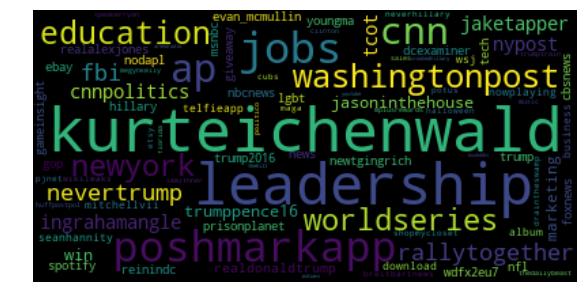

In [15]:
# Create stopword list:
stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords).fit_words(freq)

# Display the generated image:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
%%time
freq={};
for indx,ind in enumerate(des_order_centroids[1,:]):
    freq[terms[ind]] = cluster_centers_reversed[1,indx]

CPU times: user 143 µs, sys: 1e+03 ns, total: 144 µs
Wall time: 151 µs


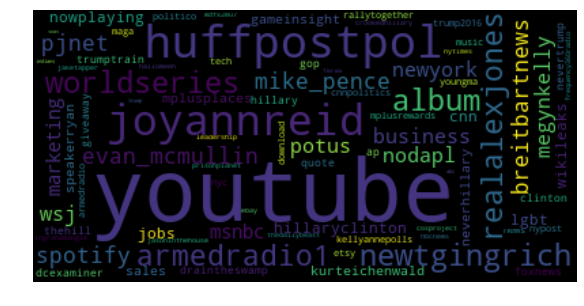

In [17]:
# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords).fit_words(freq)

# Display the generated image:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 2.1: First, you apply the k-means algorithm. Create a plot of the SSE error of the k-means algorithm as a function of the number of clusters, for k up to 20, in order to determine the optimal number of clusters.


Text(0, 0.5, 'SSE')

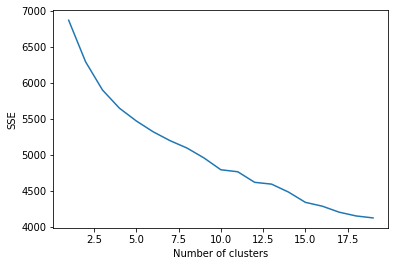

In [20]:
error = np.zeros(20)
for k in range(1,20):
    kmeans = sk_cluster.KMeans(n_clusters=k, n_init=10, max_iter=300)
    kmeans.fit_predict(tdidf)
    error[k] = kmeans.inertia_

plt.plot(range(1, 20), error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

## 2.2: Run the k-means algorithm for the optimal number of clusters you identified in the last task. Print some hashtags/handles in each cluster. From the hashtags/handles in each cluster, try to deduce what is the topic it concerns. Include your conclusions in your report.

In [22]:
kmeans = sk_cluster.KMeans(n_clusters=10, n_init=10, max_iter=300)
kmeans.fit_predict(tdidf)
printClusters(vectorizer, kmeans.cluster_centers_, 10,10)

Cluster: 0
foxnews 0.04967423410243675 24
megynkelly 1.1926223897340549e-18 48
realdonaldtrump 0.02339367710593454 75
hillaryclinton 0.004628533581171407 31
newtgingrich 0.00014401825170453665 59
seanhannity 0.05883186221127025 78
mitchellvii 0.054264076566538644 50
cnn 0.03773683543914383 10
ingrahamangle 0.01071367362080688 36
wikileaks 0.014824236649938411 94

Cluster: 1
youtube 0.9012547190261818 99
realdonaldtrump 1.1519648082658485e-18 75
hillaryclinton 0.007293100174473996 31
prisonplanet 0.003165690985838236 71
realalexjones 0.0015869352683603281 74
cnn 0.01037108135866471 10
breitbartnews 0.009409980598057623 6
wikileaks 0.0074288721156549956 94
halloween 0.0017127286899411972 29
maga 0.0009033232087100242 46

Cluster: 2
trump 0.04277579908867172 88
maga 8.673617379884035e-19 46
hillary 0.008279289518839255 30
draintheswamp 0.013669171315120292 17
realdonaldtrump 0.0017244532744026472 75
hillaryclinton 0.06644186828517779 31
clinton 0.019891862679079244 9
fbi 0.014264629297532